In [ ]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras import Model, layers
from keras.models import load_model, model_from_json

train -> 훈련용 폴더 , validation -> 확인용 폴더

In [ ]:
train_datagen = ImageDataGenerator(
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    'data/train',
    batch_size=32,
    class_mode='binary',
    target_size=(224,224))

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(
    'data/validation',
    shuffle=False,
    class_mode='binary',
    target_size=(224,224))

Found 705 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


3.

In [ ]:
conv_base = ResNet50(
    include_top=False,
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
predictions = layers.Dense(2, activation='softmax')(x)
model = Model(conv_base.input, predictions)

In [ ]:
optimizer = keras.optimizers.Adam()
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

4. 학습

In [ ]:
history = model.fit_generator(generator=train_generator,
                              epochs=3,
                              validation_data=validation_generator)

<ipython-input-12-c99589134358>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


Epoch 1/3
23/23 [==============================] - 240s 10s/step - loss: 0.3840 - accuracy: 0.8709 - val_loss: 0.0801 - val_accuracy: 0.9675
Epoch 2/3
23/23 [==============================] - 223s 10s/step - loss: 0.0996 - accuracy: 0.9589 - val_loss: 0.0535 - val_accuracy: 0.9775
Epoch 3/3
23/23 [==============================] - 223s 10s/step - loss: 0.0679 - accuracy: 0.9688 - val_loss: 0.0334 - val_accuracy: 0.9925


세이브 로드

In [ ]:
# architecture and weights to HDF5
model.save('models/keras/model.h5')

# architecture to JSON, weights to HDF5
model.save_weights('models/keras/weights.h5')
with open('models/keras/architecture.json', 'w') as f:
        f.write(model.to_json())

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# architecture and weights from HDF5
model = load_model('models/keras/model.h5')

# architecture from JSON, weights from HDF5
with open('models/keras/architecture.json') as f:
    model = model_from_json(f.read())
model.load_weights('models/keras/weights.h5')

6. 테스트

In [21]:
validation_img_paths = ["data/validation/Cafe/11.jpg",
                        "data/validation/Cafe/22.jpg",
                        "data/validation/NonCafe/39.jpg"]
img_list = [Image.open(img_path) for img_path in validation_img_paths]

In [ ]:
validation_batch = np.stack([preprocess_input(np.array(img.resize((224,224))))
                             for img in img_list])

In [ ]:
pred_probs = model.predict(validation_batch)

1/1 [==============================] - 3s 3s/step


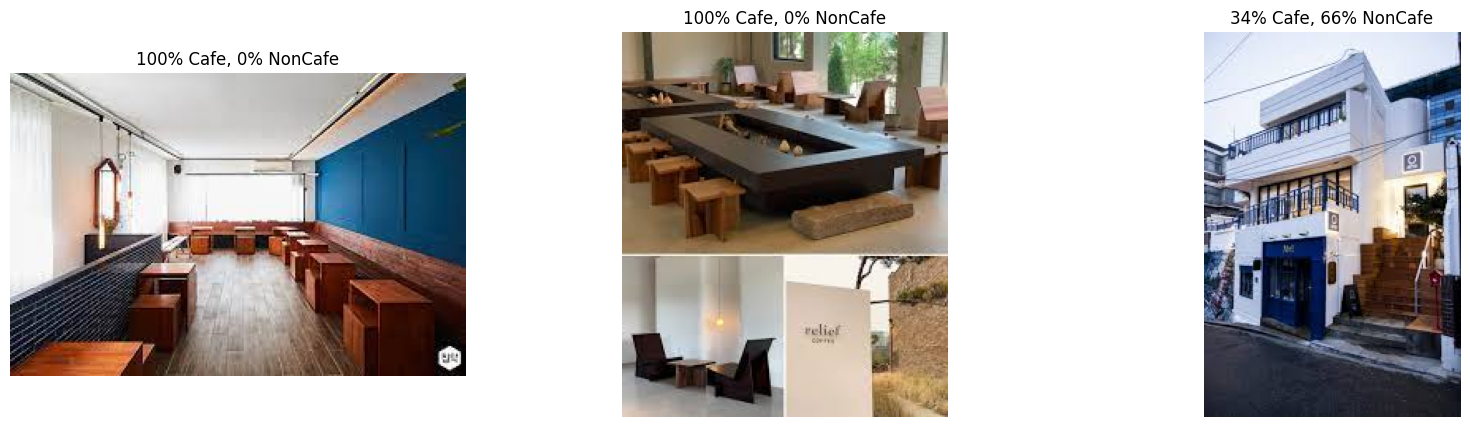

In [ ]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Cafe, {:.0f}% NonCafe".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1]))
    ax.imshow(img)

In [ ]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, (img, pred_prob) in enumerate(zip(img_list, pred_probs)):
    ax = axs[i]
    ax.axis('off')
    cafe_prob = pred_prob[0]  # "Cafe" 클래스에 대한 확률
    if cafe_prob >= 0.8:  # "Cafe" 클래스에 대한 확률이 0.8 이상인 경우만 출력
        ax.set_title("{:.0f}% Cafe".format(100 * cafe_prob))
    ax.imshow(img)

함수

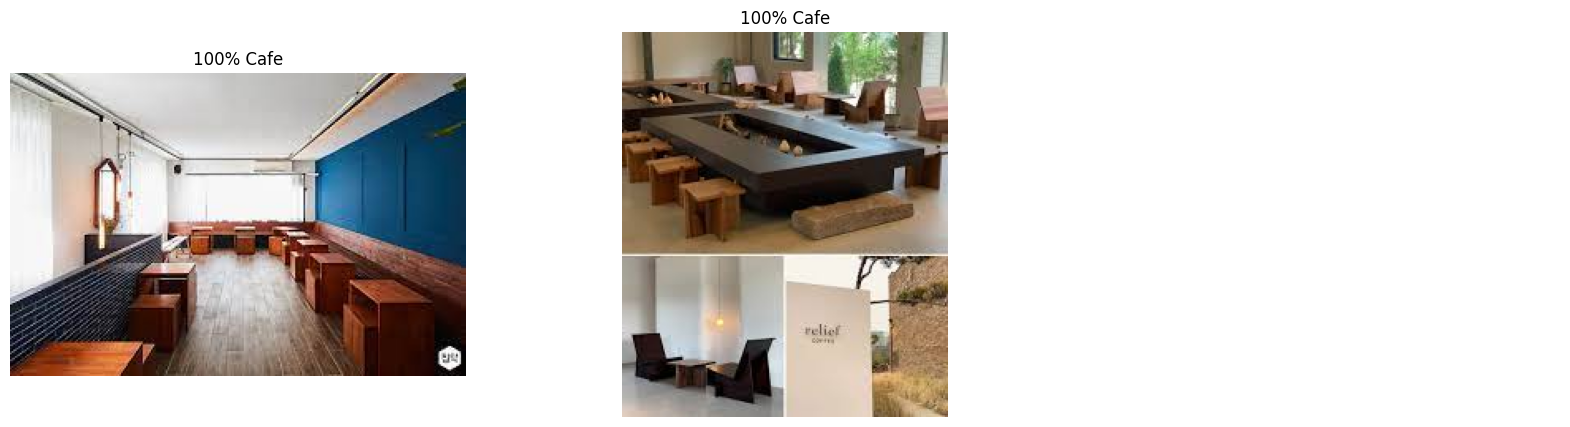

In [22]:
def visualize_cafe_only(img_list, pred_probs):
    fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
    for i, (img, pred_prob) in enumerate(zip(img_list, pred_probs)):
        ax = axs[i]
        ax.axis('off')
        cafe_prob = pred_prob[0]  # "Cafe" 클래스에 대한 확률
        if cafe_prob >= 0.8:  # "Cafe" 클래스에 대한 확률이 0.8 이상인 경우에만 이미지 출력
            ax.set_title("{:.0f}% Cafe".format(100 * cafe_prob))
            ax.imshow(img)

visualize_cafe_only(img_list, pred_probs)
